In [1]:
import os
import pandas as pd
import mlflow
import mlflow.tensorflow
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [2]:
sample_csv_path = "/Users/maurice/Documents/certification/dermdetect/csv/sample_dataset.csv"
sampled_image_dir = "/Users/maurice/Documents/data_nogit/Dermdetect/SAMPLE_20"

In [3]:
df_sample = pd.read_csv(sample_csv_path)
df_sample

,image_id,target
0,isic_0014666_1.jpg,malignant
1,isic_4974820_0.jpg,benign
2,isic_0071045_4.jpg,malignant
3,isic_5189439_3.jpg,malignant
4,isic_0817140_0.jpg,benign
...,...,...
14515,isic_0033552_0.jpg,benign
14516,isic_7490806_0.jpg,malignant
14517,isic_7072802_0.jpg,benign
14518,isic_0025505_0.jpg,benign


In [4]:
img_generator = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.3
)

In [5]:
# Générateur pour l'ensemble d'entraînement
train_generator = img_generator.flow_from_dataframe(
    dataframe=df_sample,
    directory=sampled_image_dir,
    x_col="image_id",
    y_col="target",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    subset="training",
    seed=42
)

# Générateur pour l'ensemble de validation
val_generator = img_generator.flow_from_dataframe(
    dataframe=df_sample,
    directory=sampled_image_dir,
    x_col="image_id",
    y_col="target",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    subset="validation",
    seed=42
)

Found 10164 validated image filenames belonging to 2 classes.
Found 4356 validated image filenames belonging to 2 classes.


In [6]:
base_model  = ResNet50(
                        weights='imagenet',
                        include_top=False,
                        input_shape=(128, 128, 3)
                        )

base_model.trainable = False  # Freeze the base model

In [7]:
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [8]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',  
              metrics=['accuracy', 
                       Precision(name="precision"), 
                       Recall(name="recall"), 
                       tf.keras.metrics.AUC(name="auc")]
              )

In [9]:
history = model.fit(
    train_generator,
    epochs=4,
    validation_data=val_generator,
    verbose=1
    )

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/4
318/318 ━━━━━━━━━━━━━━━━━━━━ 68s 208ms/step - accuracy: 0.5603 - auc: 0.5828 - loss: 0.7686 - precision: 0.5603 - recall: 0.5603 - val_accuracy: 0.6972 - val_auc: 0.7907 - val_loss: 0.5783 - val_precision: 0.6972 - val_recall: 0.6972
Epoch 2/4
318/318 ━━━━━━━━━━━━━━━━━━━━ 65s 206ms/step - accuracy: 0.6881 - auc: 0.7589 - loss: 0.5873 - precision: 0.6881 - recall: 0.6881 - val_accuracy: 0.6019 - val_auc: 0.7174 - val_loss: 0.7011 - val_precision: 0.6019 - val_recall: 0.6019
Epoch 3/4
318/318 ━━━━━━━━━━━━━━━━━━━━ 71s 223ms/step - accuracy: 0.7098 - auc: 0.7857 - loss: 0.5594 - precision: 0.7098 - recall: 0.7098 - val_accuracy: 0.7300 - val_auc: 0.8268 - val_loss: 0.5272 - val_precision: 0.7300 - val_recall: 0.7300
Epoch 4/4
318/318 ━━━━━━━━━━━━━━━━━━━━ 70s 219ms/step - accuracy: 0.7126 - auc: 0.7908 - loss: 0.5528 - precision: 0.7126 - recall: 0.7126 - val_accuracy: 0.7022 - val_auc: 0.8048 - val_loss: 0.5366 - val_precision: 0.7022 - val_recall: 0.7022


In [11]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Obtenir les vraies étiquettes
y_true = val_generator.classes  

model.evaluate(val_generator)

# Faire des prédictions
y_pred_probs = model.predict(val_generator)  # Probabilités prédites

# Convertir les probabilités en classes avec softmax
y_pred = np.argmax(y_pred_probs, axis=1)  # Sélectionne la classe avec la probabilité max

# Afficher les scores globaux
print("📊 Scores de classification sur l'ensemble de validation :")
print(classification_report(y_true, y_pred ))

# Calculer l'AUC manuellement
auc_score = roc_auc_score(y_true, y_pred_probs[:, 1])  # Prend la colonne associée à "Malin"
print(f"AUC Score: {auc_score:.4f}")


137/137 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.6968 - auc: 0.8008 - loss: 0.5395 - precision: 0.6968 - recall: 0.6968
137/137 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step
📊 Scores de classification sur l'ensemble de validation :
              precision    recall  f1-score   support

           0       0.64      0.92      0.76      2175
           1       0.86      0.48      0.62      2181

    accuracy                           0.70      4356
   macro avg       0.75      0.70      0.69      4356
weighted avg       0.75      0.70      0.69      4356

AUC Score: 0.8560


In [16]:
print("Format de y_true:", y_true[:5])


Format de y_true: [1, 0, 1, 1, 0]


In [12]:
print(y_true[:3], y_pred[:3])

[1, 0, 1] [1 0 0]


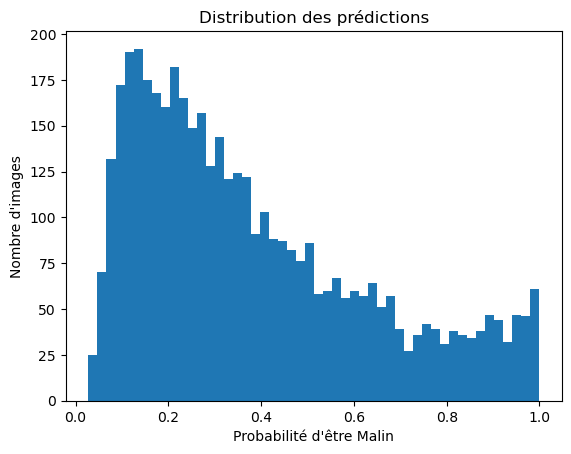

In [13]:
import matplotlib.pyplot as plt

plt.hist(y_pred_probs[:, 1], bins=50)
plt.xlabel("Probabilité d'être Malin")
plt.ylabel("Nombre d'images")
plt.title("Distribution des prédictions")
plt.show()


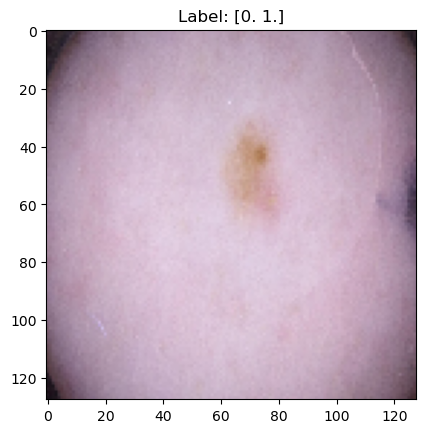

In [14]:
images, labels = next(val_generator)

plt.imshow(images[1])
plt.title(f"Label: {labels[0]}")
plt.show()

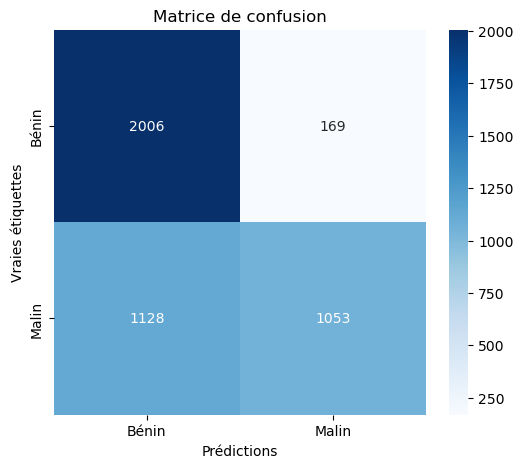

In [15]:
import seaborn as sns
# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Affichage avec Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bénin", "Malin"], yticklabels=["Bénin", "Malin"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("Matrice de confusion")
plt.show()
